In [1]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import simulation
from importlib import resources
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [2]:
#autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
# path towards fourier coefficients
f_coeffs_path = (
    resources.files("CoPhaser") / "resources" / "fourier_coefficients_RPE.csv"
)
f_coeffs = pd.read_csv(f_coeffs_path, index_col=0)
f_coeffs.drop(
    "FEN1", inplace=True
)  # drop FEN1 as it is not expressed at 10000 seqencing depth

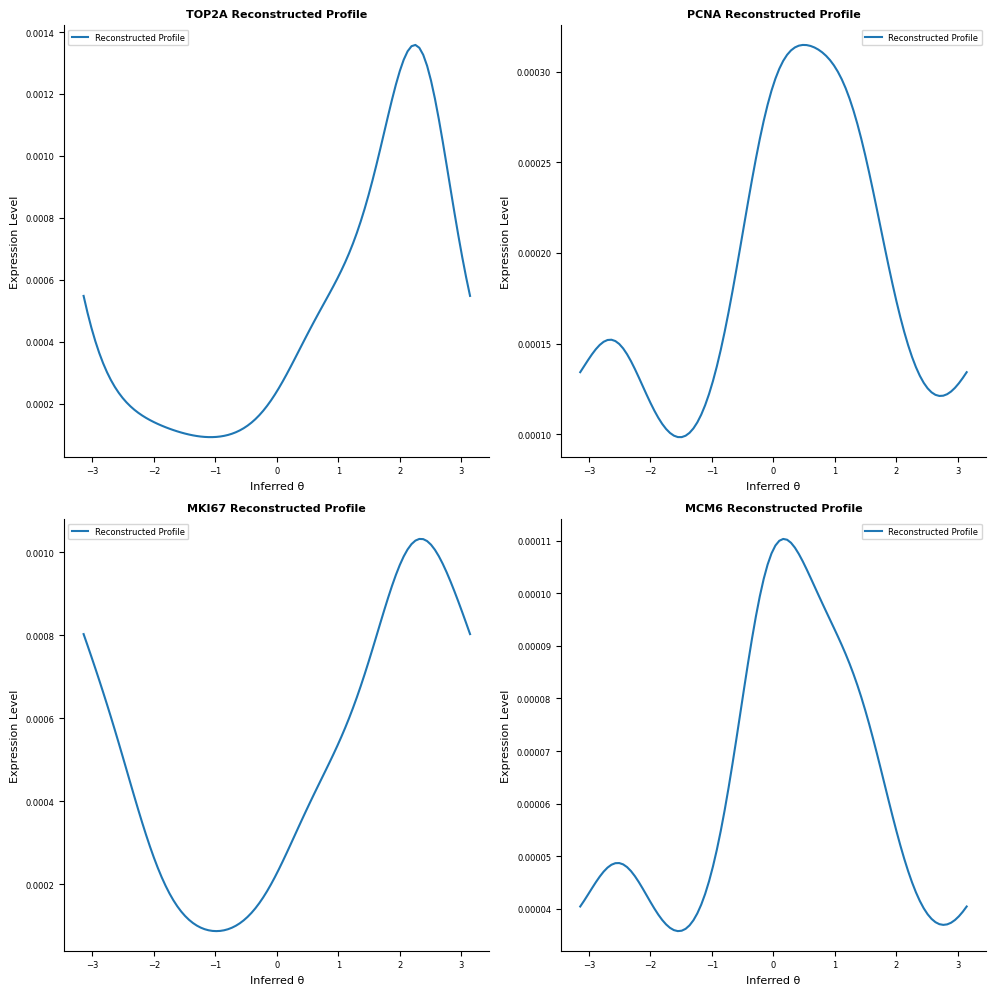

In [36]:
# draw reconstructed profiles for TOP2A, PCNA, MKI67, MCM6
genes_to_plot = ["TOP2A", "PCNA", "MKI67", "MCM6"]
ncols = 2
nrows = np.ceil(len(genes_to_plot) / ncols).astype(int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
axs = axs.flatten()
for i, gene in enumerate(genes_to_plot):
    if i >= len(axs):
        break
    A_0 = f_coeffs.loc[gene, "A_0"]
    A_1 = f_coeffs.loc[gene, "A_1"]
    B_1 = f_coeffs.loc[gene, "B_1"]
    A_2 = f_coeffs.loc[gene, "A_2"]
    B_2 = f_coeffs.loc[gene, "B_2"]
    A_3 = f_coeffs.loc[gene, "A_3"]
    B_3 = f_coeffs.loc[gene, "B_3"]

    theta_vals = np.linspace(-np.pi, np.pi, 100)
    reconstructed_profile = (
        A_0
        + A_1 * np.cos(theta_vals)
        + B_1 * np.sin(theta_vals)
        + A_2 * np.cos(2 * theta_vals)
        + B_2 * np.sin(2 * theta_vals)
        + A_3 * np.cos(3 * theta_vals)
        + B_3 * np.sin(3 * theta_vals)
    )
    reconstructed_profile = np.exp(reconstructed_profile)

    axs[i].plot(theta_vals, reconstructed_profile, label="Reconstructed Profile")
    axs[i].set_title(f"{gene} Reconstructed Profile")
    axs[i].set_xlabel("Inferred θ")
    axs[i].set_ylabel("Expression Level")
    axs[i].legend()
plt.tight_layout()

In [37]:
n_cells = 10000
pseudotimes = np.linspace(0, 1, n_cells)

<Axes: xlabel='A_0', ylabel='Count'>

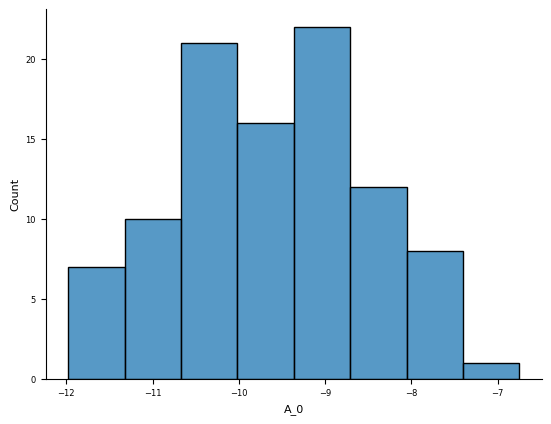

In [38]:
sns.histplot(f_coeffs["A_0"])

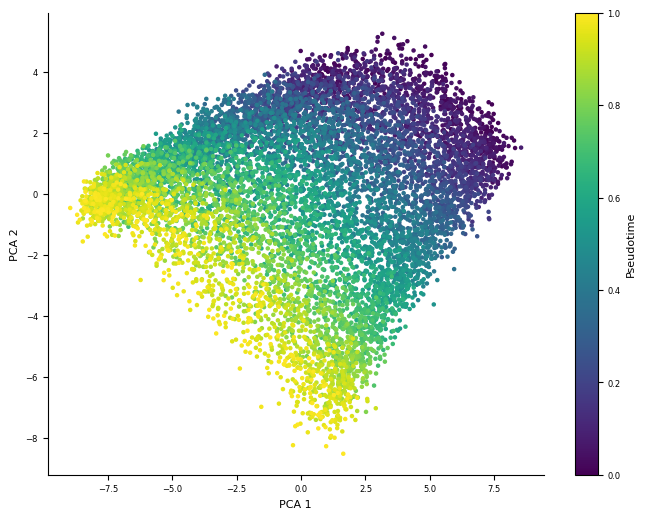

Text(0, 0.5, 'PCA 3')

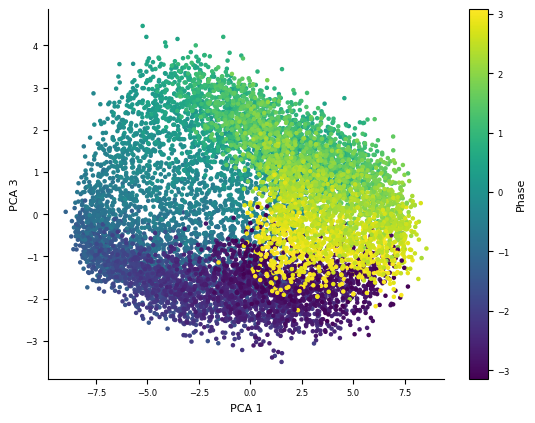

In [39]:
# PCA on simulated counts
from sklearn.decomposition import PCA

np.random.seed(0)
f_coeffs["A_0_DIFF"] = f_coeffs["A_0"]
f_coeffs.loc[::3, "A_0_DIFF"] = f_coeffs.loc[::3, "A_0"] + np.random.uniform(
    -5, 5, size=f_coeffs.loc[::3, "A_0"].shape[0]
)
f_coeffs.loc["TOP2A", "A_0_DIFF"] = f_coeffs.loc["TOP2A", "A_0"] + 2.5
# + np.random.uniform(
#     -3, 3, size=f_coeffs.loc[:,"A_0"].shape[0]
# )
lambda_start = 0.8
lambda_end = 1.7
rhythmic_counts, phases, fractions, mu_gt = (
    simulation.simulate_counts_rhythmic_shifting(
        fourrier_coefficients=f_coeffs,
        n_cells=int(n_cells),
        alphas=0.1,
        library_size=1e4,
        lambda_=(lambda_start, lambda_end),
        pseudotimes=pseudotimes,
    )
)

pca = PCA(n_components=5)
pca_results = pca.fit_transform(np.log1p(rhythmic_counts / 10000 * 1e4))
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    pca_results[:, 0],
    pca_results[:, 1],
    c=pseudotimes,
    s=5,
)
plt.colorbar(sc, label="Pseudotime")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
plt.scatter(
    pca_results[:, 0],
    pca_results[:, 2],
    c=phases,
    s=5,
)
plt.colorbar(label="Phase")
plt.xlabel("PCA 1")
plt.ylabel("PCA 3")

Text(0, 0.5, 'PCA Inferred Phase')

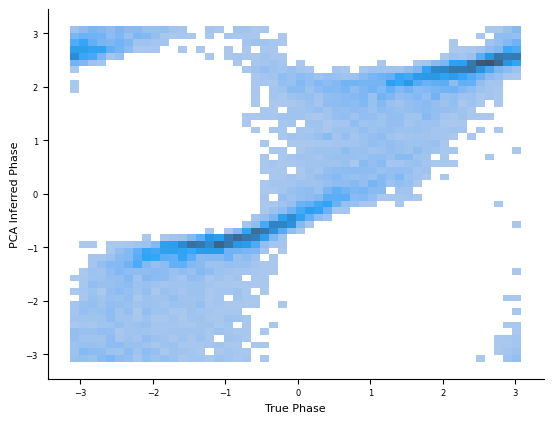

In [40]:
pca_phases = np.arctan2(pca_results[:, 2], pca_results[:, 0])
pca_phases = utils.align_phases(pca_phases, phases)
sns.histplot(y=pca_phases, x=phases, bins=50)
plt.xlabel("True Phase")
plt.ylabel("PCA Inferred Phase")

In [41]:
n_variable_genes = 2000
fold_changes = np.random.uniform(-3, 3, size=n_variable_genes)
non_rhythmic_counts, base_fraction_unscaled = (
    simulation.generate_gradual_shifting_counts(
        n_genes=10000,
        n_cells=int(n_cells),
        fold_changes=fold_changes,
        target_fractions=1 - fractions,
        alphas=0.1,
        library_size=1e4,
        pseudotimes=pseudotimes,
    )
)

(10000, 10000) (10000,)


<Axes: ylabel='Count'>

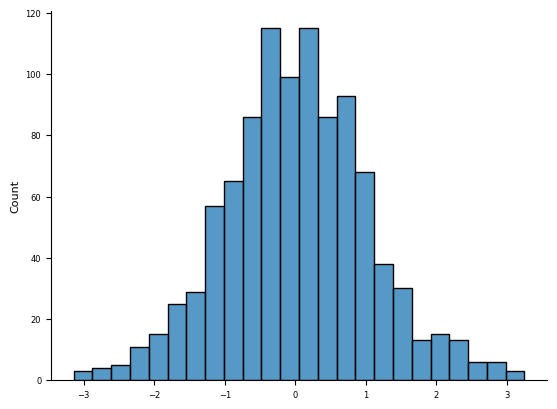

In [42]:
sns.histplot(np.random.normal(0, 1, 1000))

In [43]:
# combine in a csr matrix the two count matrices


combined_counts = hstack([rhythmic_counts, non_rhythmic_counts]).tocsr()
combined_counts.shape

(10000, 10097)

<Axes: >

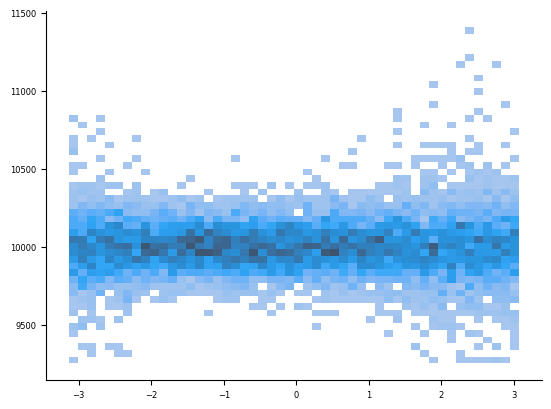

In [44]:
sns.histplot(x=phases, y=combined_counts.sum(axis=1).A1, bins=50)

Text(0.5, 1.0, 'Distribution of Fold Changes in Non-Rhythmic Genes')

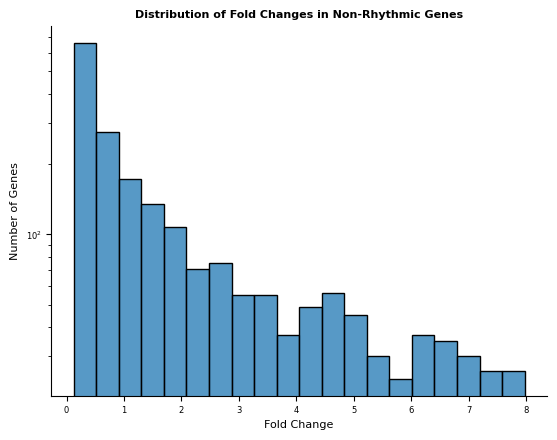

In [45]:
sns.histplot(2**fold_changes)
plt.yscale("log")
plt.xlabel("Fold Change")
plt.ylabel("Number of Genes")
plt.title("Distribution of Fold Changes in Non-Rhythmic Genes")

In [46]:
adata = anndata.AnnData(X=combined_counts)
var_names = [f"GENE_{i}" for i in range(combined_counts.shape[1])]
var_names[: len(f_coeffs)] = f_coeffs.index.tolist()
var_names[len(f_coeffs) : len(f_coeffs) + n_variable_genes] = [
    f"VARIABLE_GENE_{i}" for i in range(n_variable_genes)
]
adata.var_names = var_names
adata.layers["counts"] = adata.X.copy()

In [47]:
variable_genes = adata.var_names[len(f_coeffs) : len(f_coeffs) + n_variable_genes]
rhythmic_genes = adata.var_names[: len(f_coeffs)]

Epoch 1/200, elbo_loss: 5960.2181, kl_div_f: 4.6778, kl_div_z: 40.9905, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.2441, entropy_loss: -448.8192, radial_variance: 22.5644, radius: 84.7027, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 5618.6659
Epoch 2/200, elbo_loss: 3736.6172, kl_div_f: 4.6282, kl_div_z: 8.2128, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3065, entropy_loss: -661.3005, radial_variance: 7.3166, radius: 9.0525, L1_mu_z: 0.0000, MI_loss: -0.0000, total_loss: 3091.6856
Epoch 3/200, elbo_loss: 3626.7500, kl_div_f: 4.5668, kl_div_z: 8.2190, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3705, entropy_loss: -674.1028, radial_variance: 5.3134, radius: 9.2122, L1_mu_z: 0.0000, MI_loss: 0.0003, total_loss: 2967.1854
Epoch 4/200, elbo_loss: 3530.2668, kl_div_f: 4.5020, kl_div_z: 8.2412, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3763, en

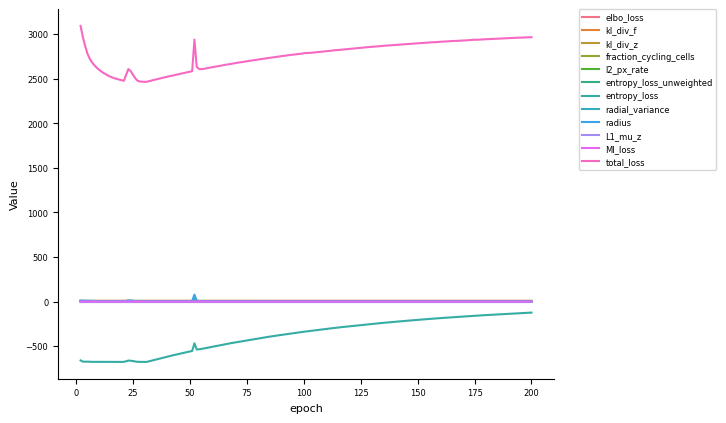

In [48]:
model = CoPhaser(
    rhythmic_genes,
    variable_genes,
    n_latent=2,
)
model.load_anndata(adata, layer_to_use="counts")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    non_rhythmic_likelihood_weight=1,
    rhythmic_likelihood_weight=10,
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=50,
    cycling_status_prior=1,
    MI_weight=50,
    entropy_weight_factor=200,
    MI_detach="none",
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=512,
)

<Axes: ylabel='Count'>

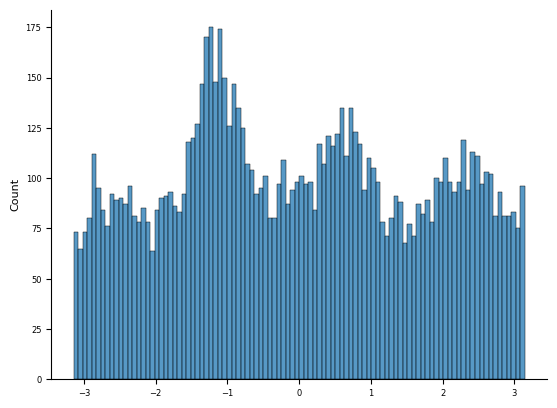

In [49]:
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"]
results_shifts = utils.get_best_shift_direction(thetas, phases)
thetas = utils.normalize_angles(
    results_shifts["direction"] * thetas - results_shifts["shift"]
)
mu_pred, theta_pred = simulation.get_mu_pred(
    model, generative_outputs, space_outputs, results_shifts, n_theta=mu_gt.shape[2]
)
theta_pred = theta_pred * results_shifts["direction"] - results_shifts["shift"]
sns.histplot(thetas, bins=100)

height_ratios_scaling: [3, 2, 2, 3]


<Axes: label='B'>

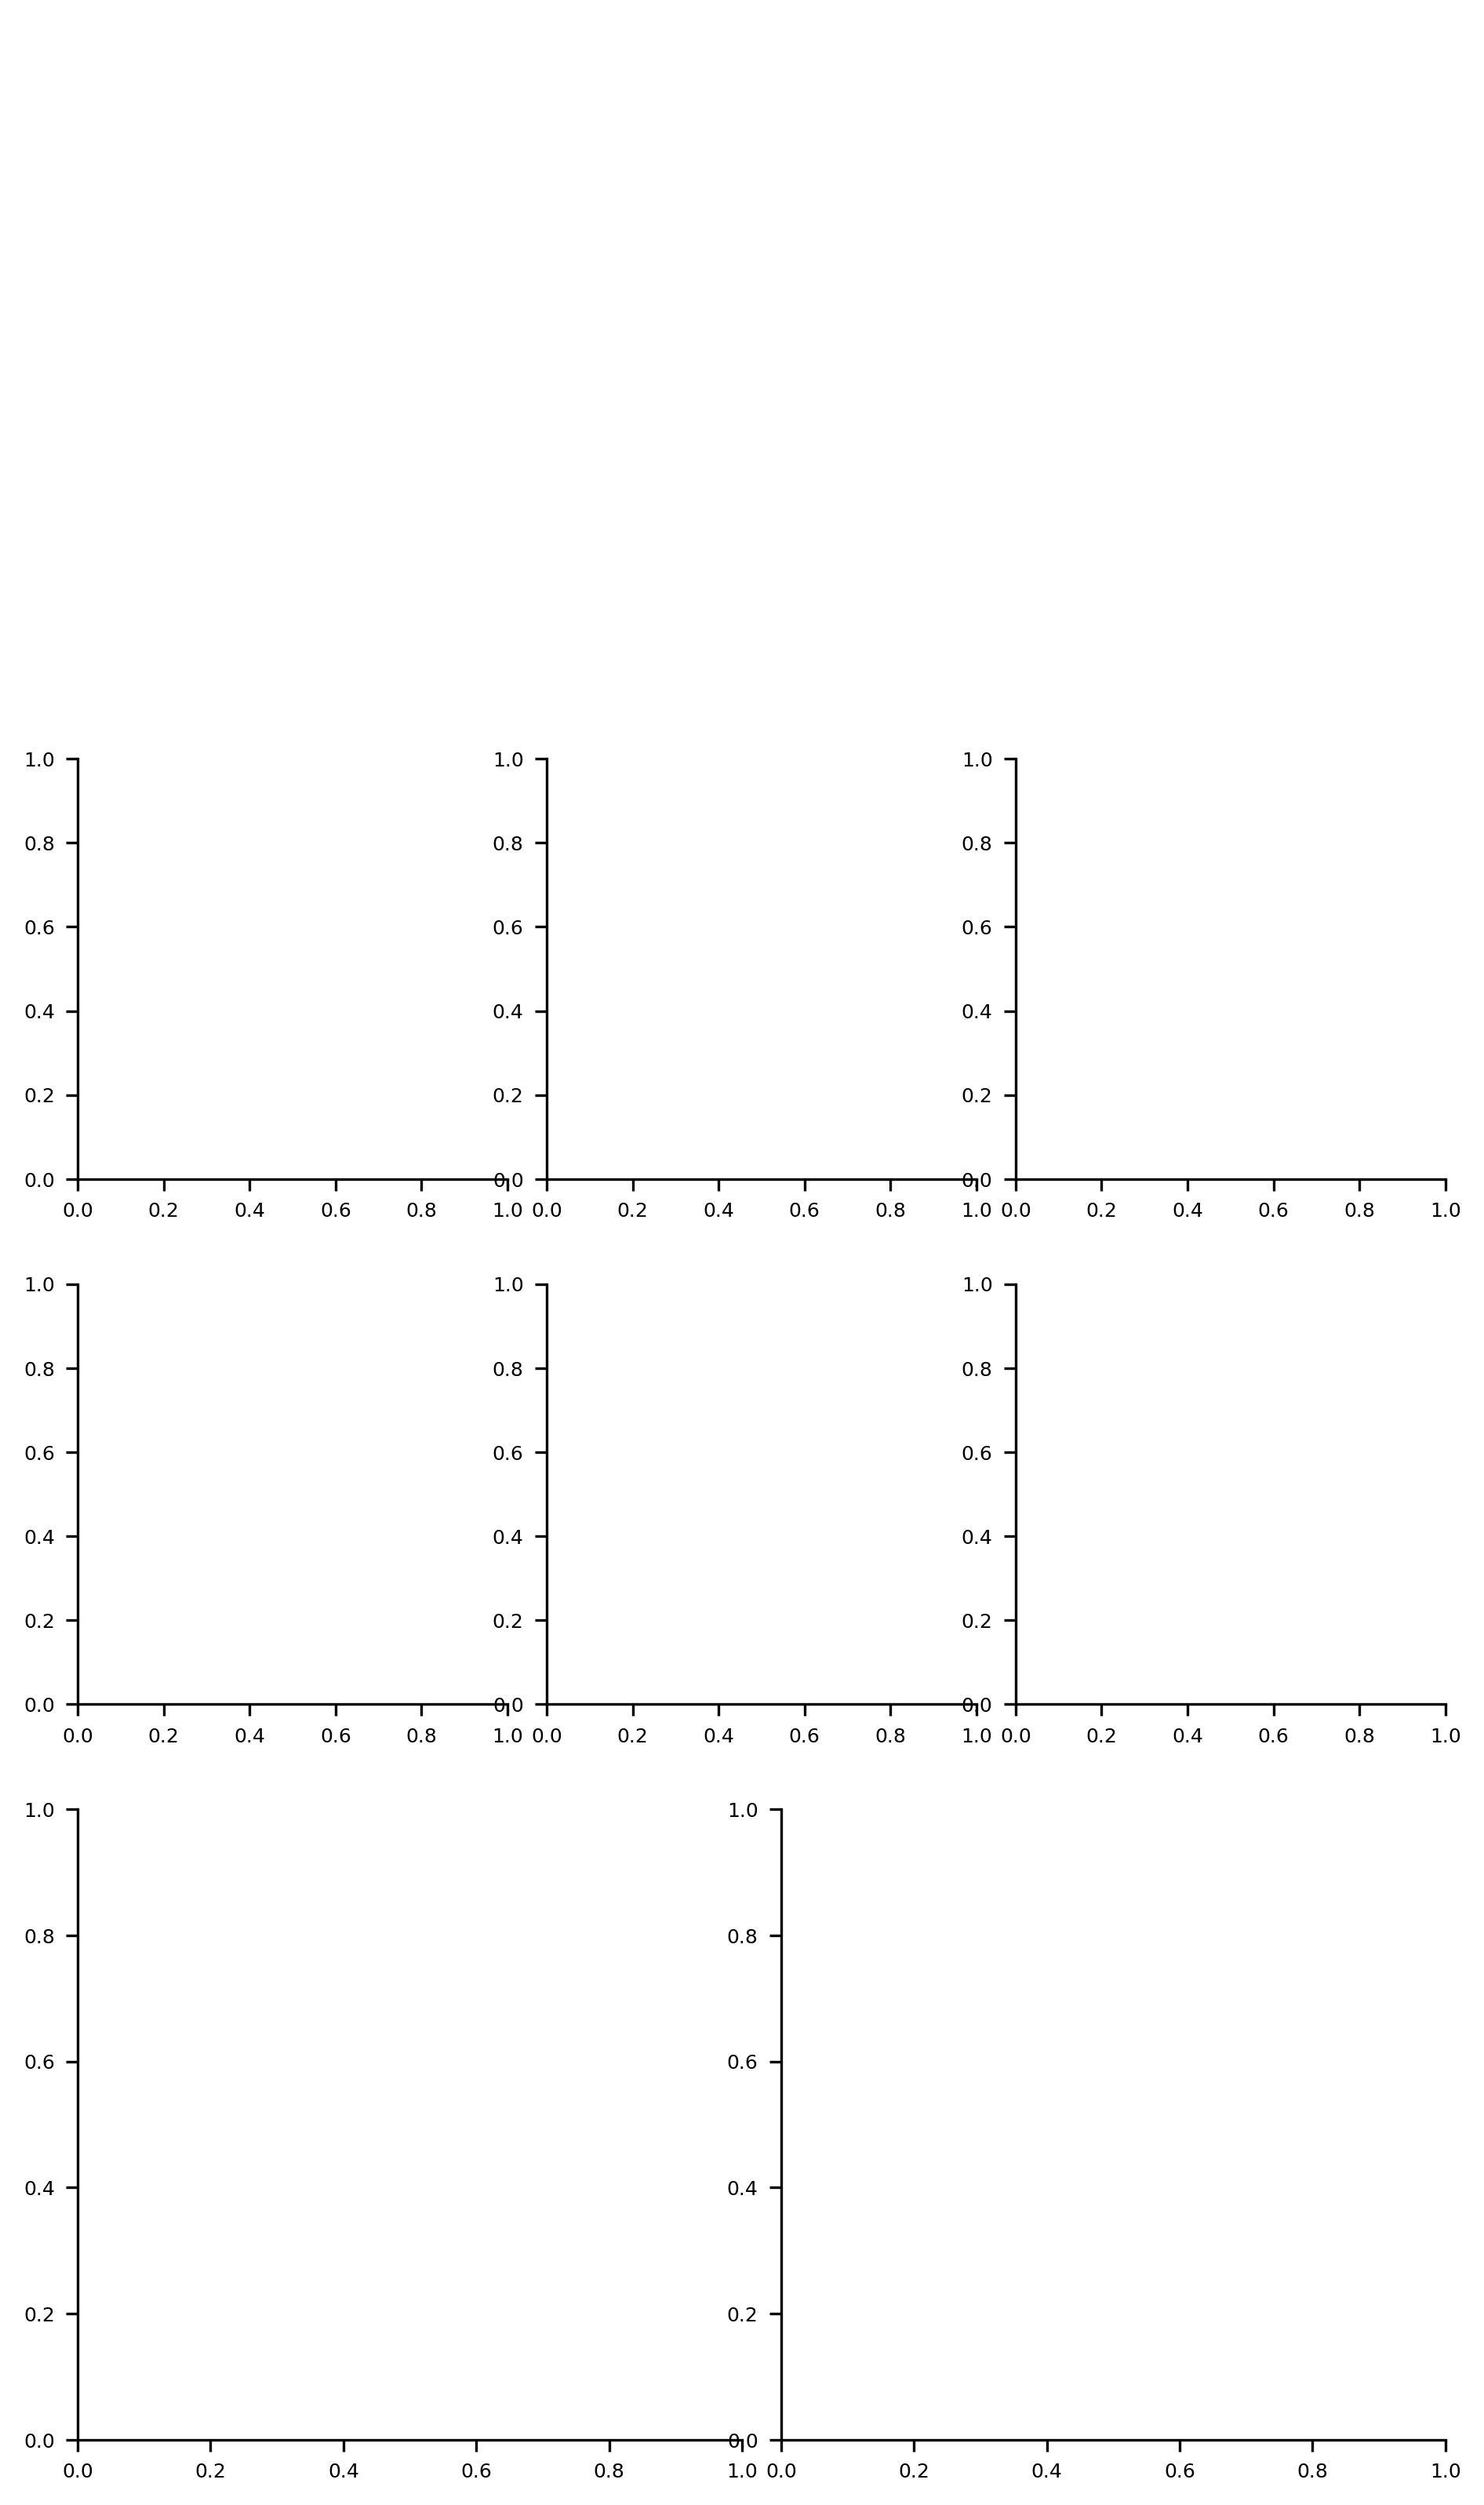

In [50]:
mosaic = [["A", "B"], ["C", "D", "E"], ["F", "G", "H"], ["I", "J"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=20)
plot_helpers.make_blank_panel(axs["A"])
plot_helpers.make_blank_panel(axs["B"])

In [51]:
for ax in [
    axs["C"],
    axs["D"],
    axs["E"],
    axs["F"],
    axs["G"],
    axs["H"],
    axs["I"],
    axs["J"],
]:
    ax.set_box_aspect(1)

In [52]:
thetas = utils.align_phases(thetas, phases)

In [53]:
lambda_vals = (1 - pseudotimes) * lambda_start + pseudotimes * lambda_end
ax = axs["C"]
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = ax.scatter(
    space_outputs["z"][:, 0],
    space_outputs["z"][:, 1],
    c=pseudotimes,
    edgecolor=None,
    s=5,
    alpha=0.5,
    cmap=cmap,
)
import matplotlib.cm as cm

norm = plt.Normalize(vmin=pseudotimes.min(), vmax=pseudotimes.max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label="Pseudotime")
cbar.ax.set_yticklabels([])
ax.set_title("z Space")
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("z1")
ax.set_ylabel("z2")

Text(13.33333333333329, 0.5, 'z2')

In [54]:
cells_projected = space_outputs["x_projected"].detach().numpy()
ax = axs["D"]
sns.scatterplot(
    x=cells_projected[:, 0],
    y=cells_projected[:, 1],
    ax=ax,
    alpha=0.2,
    edgecolor=None,
    s=2,
    c=phases,
    cmap="hsv",
)
ax.set_title("f Space")
# remove ticks
ax.set_xticks([])
ax.set_yticks([])

[]

In [55]:
ax = axs["E"]
plotting.modify_axis_labels(ax=ax, axis="both", step=0.5)
sns.histplot(x=phases, y=thetas, bins=50, cmap="rocket_r", ax=ax)
ax.plot(
    [-np.pi, np.pi], [-np.pi, np.pi], color="lightgray", linestyle="--", linewidth=1
)
ax.set_ylabel("Inferred Phase")
ax.set_xlabel("Simulated Phase")
ax.set_title("Phase Inference Accuracy")
np.abs(utils.normalize_angles(thetas - phases)).mean()

tensor(0.1629, dtype=torch.float64)

In [56]:
mu_pred, theta_pred = simulation.get_mu_pred(
    model, generative_outputs, space_outputs, results_shifts, n_theta=mu_gt.shape[2]
)
theta_pred = theta_pred * results_shifts["direction"] - results_shifts["shift"]

In [57]:
mu_pred.shape

(10000, 97, 100)

In [58]:
ax = axs["F"]
pearson_per_cell_genes = pearsonr(np.log2(mu_pred), np.log2(mu_gt), axis=-1)[0]
sns.histplot(
    pearson_per_cell_genes[:, model.rhythmic_gene_names != "FEN1"].flatten(),
    bins=100,
    ax=ax,
)
ax.set_xlabel("Pearson Correlation Coefficient")
ax.set_title("Expression Profiles Correlations")

Text(0.5, 1.0, 'Expression Profiles Correlations')

In [59]:
ax = axs["G"]
sns.histplot(
    x=lambda_vals, y=generative_outputs["lambda"].flatten().detach().numpy(), ax=ax
)
ax.set_xlabel("Simulated λ")
ax.set_ylabel("Inferred λ")
ax.set_title("Inferred λ Accuracy")

Text(0.5, 1.0, 'Inferred λ Accuracy')

In [60]:
# sns.histplot(x=adata[:, "FEN1"].layers["counts"].toarray().flatten(), discrete=True)
# plt.yscale("log")

In [61]:
# create a 10000,n_genes array with the pseudotimes
discrete_gt = pd.qcut(
    (
        np.log2(mu_gt[:, ::3, :]).mean(axis=2)
        - np.log2(mu_gt[:, ::3, :]).mean(axis=2).mean(axis=0)
    ).flatten(),
    100,
)
discrete_gt = [x.mid for x in discrete_gt]
i = [i for i in range(0, mu_gt.shape[1], 3)]
ax = axs["H"]
sns.lineplot(
    x=discrete_gt,
    y=(
        np.log2(mu_pred[:, ::3, :]).mean(axis=2)
        - np.log2(mu_pred[:, ::3, :]).mean(axis=2).mean(axis=0)
    ).flatten(),
    ax=ax,
    errorbar="sd",
)
ax.plot([-2.1, 2.1], [-2.1, 2.1], color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Simulated Δμ ")
ax.set_ylabel("Inferred Δμ")
ax.set_title("Inferred Δμ Accuracy")

Text(0.5, 1.0, 'Inferred Δμ Accuracy')

In [62]:
def plot_gene_expression_profile(
    ax, gene_name, mu_values, gene_names, type_label="Simulated", max_value=None
):
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.lineplot(
        np.log2(mu_values[::20, gene_names == gene_name].squeeze().T),
        legend=False,
        dashes=False,
        alpha=1,
        linewidth=2,
        palette=sns.cubehelix_palette(n_colors=500),
        ax=ax,
    )
    # Add colorbar with rainbow colormap

    norm = plt.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label="Pseudotime")
    cbar.ax.set_yticklabels([])
    ax.set_ylabel(f"{type_label} log2 Expression")
    ax.set_title(f"{type_label} Expression Profile for {gene_name}")
    ax.set_xticks([])
    ax.set_xlabel("Phase")
    if max_value is not None:
        ax.set_ylim(top=max_value)


plot_gene_expression_profile(
    axs["I"],
    "TOP2A",
    mu_gt,
    model.rhythmic_gene_names,
    type_label="Simulated",
)
plt.show()
plot_gene_expression_profile(
    axs["J"],
    "TOP2A",
    mu_pred,
    model.rhythmic_gene_names,
    type_label="Predicted",
)

In [63]:
# # to save to reprouce figure
# import pickle

# to_save = {
#     "thetas": thetas,
#     "phases": phases,
#     "mu_gt": mu_gt,
#     "mu_pred": mu_pred,
#     "generative_outputs": generative_outputs,
#     "space_outputs": space_outputs,
#     "results_shifts": results_shifts,
#     "pseudotimes": pseudotimes,
#     "lambda_start": lambda_start,
#     "lambda_end": lambda_end,
#     "rhythmic_gene_names": model.rhythmic_gene_names,
# }
# with open("data/res_simulation.pkl", "wb") as f:
#     pickle.dump(to_save, f)